**Cleaning & EDA (Part 2)**

Some topics covered in this notebook include:


1. [Read in data](#rid)
2. [Getting More Data](#gmd)
4. [Univariate & Bivariate Analysis (Numeric and Categorical)](#u_b_n_c)
5. [Bivariate Analysis - (Numeric Vs Numeric)](#ba_n)
6. [Multivariate Analysis](#ma)


In [1]:
# My own module
import eda_assist as ea

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.svm import OneClassSVM
from sklearn.impute import KNNImputer
# from sklearn.covariance import EllipticEnvelope
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Get all numbers showing to 2dp
pd.options.display.float_format = "{:.2f}".format

# To allow plots to appear nicely in the notebook
plt.style.use('seaborn-whitegrid') 
%config InlineBackend.figure_format = 'svg'

# So that it updates with any changes made in .py files 
%load_ext autoreload
%autoreload 2

#### <span style="color:black"><u>**Read in Data**</u><a name="rid"></a></span>

In [2]:
train = pd.read_csv('../data/training.csv', dtype={'Year': int})
test = pd.read_csv('../data/testing.csv', dtype={'Year': int})

ea.summarise(train)

Summary Below
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2094 entries, 0 to 2093
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            2094 non-null   object 
 1   Year               2094 non-null   int64  
 2   InfantMortality    2094 non-null   float64
 3   Health_exp         2065 non-null   float64
 4   Life_exp           2094 non-null   float64
 5   GDP_cap            2075 non-null   float64
 6   Employment         2052 non-null   float64
 7   Status             2094 non-null   object 
 8   MeanSchooling      2056 non-null   float64
 9   ElectricityAccess  2027 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 163.7+ KB
None


Year  InfantMortality  Health_exp  Life_exp      GDP_cap  \
count        2094.00          2094.00     2065.00   2094.00      2075.00   
mean         2009.01            27.75        6.12     70.25     12482.86   
std             5.49            26.91        2.63      8.86     18187.26   
min          2000.00             1.70        1.03     39.44       111.93   
25%          2004.00             6.90        4.06     65.35      1244.36   
50%          2009.00            16.45        5.74     72.38      4167.67   
75%          2014.00            42.60        7.99     76.80     14778.25   
max          2018.00           139.50       20.41     83.60    116654.26   
Variance       30.15           724.15        6.92     78.51 330776474.56   
IQR            10.00            35.70        3.93     11.45     13533.89   
Q3 + 1.5*IQR 2029.00            96.15       13.88     93.97     35079.08   
Q1 - 1.5*IQR 1989.00           -46.65       -1.83     48.18    -19056.47   
mu + 3*sigma 2025.49           108.48       14.01     96.83     67044.65   
mu - 3*sigma 1992.54           -52.98       -1.77     43.67    -42078.92   

              Employment  MeanSchooling  ElectricityAccess  
count            2052.00        2056.00            2027.00  
mean               58.30           7.91              79.07  
std                11.21           3.24              30.59  
min                30.61           1.10               1.90  
25%                50.98           5.20              65.45  
50%                57.73           8.20              98.22  
75%                65.57          10.60             100.00  
max                87.82          14.10             100.00  
Variance          125.63          10.49             935.93  
IQR                14.60           5.40              34.55  
Q3 + 1.5*IQR       87.47          18.70             151.83  
Q1 - 1.5*IQR       29.08          -2.90              13.62  
mu + 3*sigma       91.93          17.62             170.85  
mu - 3*sigma       24.68          -1.81             -12.71

#### <span style="color:black"><u>**Getting More Data**<a name="gmd"></a><u></span>

- HDI is "a statistic composite index of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development." ~ Wikipedia
- Could be nice to use the HDI score of a particular country instead of [one-hot-encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) over 100 countries, which can lead to [the curse of dimensionality](https://towardsdatascience.com/the-curse-of-dimensionality-50dc6e49aa1e)
- Though adding variables like HDI might cause <u>multicollinearity</u> as the HDI is in itself a measure calculated using factors such as education and mortality rates etc., which are variables already in our dataset


In [3]:
hdi = pd.read_csv('../data/hdi.csv')
hdi.sample(10)

Country  HDI  Year
2390              Argentina 0.83  2013
901                Barbados 0.79  2005
2338              Singapore 0.92  2012
2384   United Arab Emirates 0.84  2013
495            Sierra Leone 0.33  2002
387   Republic of the Congo 0.47  2002
1073                 Greece 0.86  2006
3098            El Salvador 0.67  2016
1262   United Arab Emirates 0.82  2007
2780                Bolivia 0.70  2015

Which countries are in our **train** and **test** dataset but not in our **hdi** dataset

In [4]:
train_countries = set(train.Country)
test_countries = set(test.Country)
hdi_countries = set(hdi.Country)

# A difference B: In train not in hdi
print(train_countries.difference(hdi_countries))

# B difference A: Get everything in test not in hdi
print(test_countries.difference(hdi_countries))

{'Brunei Darussalam', 'Russian Federation', 'Syrian Arab Republic', 'Cabo Verde'}
{'Brunei Darussalam', 'Russian Federation', 'Syrian Arab Republic', 'Cabo Verde'}


- These countries most likely are actually in the **hdi** dataset but are just represented differently
- Perhaps in the hdi dataset it was just 'Syria' rather than 'Syrian Arab Republic'

In [5]:
# Search substrings to see if these countries really are hidden in here somewhere
correct_names = hdi['Country'].str.lower().str.contains('russia|cabo|verde|brunei|syria')
hdi.loc[correct_names, 'Country'].unique()  # It's all there

array(['Brunei', 'Cape Verde', 'Russia', 'Syria'], dtype=object)

In [6]:
# Correct it to the strings displayed above in both our train and test set
train = (
    train.replace('Russian Federation', 'Russia').
    replace('Cabo Verde', 'Cape Verde').
    replace('Brunei Darussalam', 'Brunei').
    replace('Syrian Arab Republic', 'Syria')
)

# For the testing set
test = (
    test.replace('Russian Federation', 'Russia').
    replace('Cabo Verde', 'Cape Verde').
    replace('Brunei Darussalam', 'Brunei').
    replace('Syrian Arab Republic', 'Syria')
)

In [7]:
# Match country and year with its hdi rank
train = pd.merge(train, hdi, on = ['Country', 'Year'], how='inner')

# Do the same with the test set
test = pd.merge(test, hdi, on = ['Country', 'Year'], how='inner')

#### <span style="color:black"><u>**Univariate Analysis - Categorical**<a name="uac"></a><u></span>
* Bars & pies

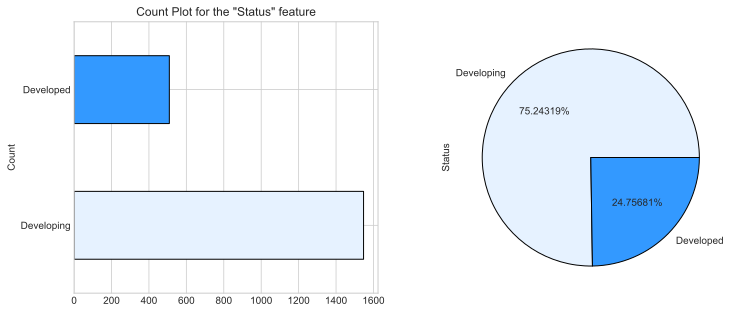

In [8]:
# Bar + Pie
ea.basic_categorical_variable_analysis(train, 'Status')

#### <span style="color:black"><u>**Univariate & Bivariate Analysis - Numeric and Categorical**<a name="u_b_n_c"></a><u></span>
    
* Distributions and the skewness of these distributions:
* Quartiles & Boxplots:
* Interpreting results to ascertain potential univariate outliers

#### <u>Distributions & their Skewness</u>

<ins>Skewness</ins>

* Skewness occurs when the data are distributed asymetrically (longer tail on one side)
* A left skewed (negative skewed) distribution has a longer tail on the left
* A right skewed (positive skewed) distribution has a longer tail on the right
* Will be using the 'Fisher-Pearson coefficient of skewness' to measure how asymetric the distribution of a variable is

In situations where the data has a skewed distribution, it is possible to detect univariate outliers using quartiles and the Inter-Quartile Range (IQR). We unfortunately can't use the [empirical rule](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/empirical-rule-2/) since none of our variables follow a normal distribution. From the summary table earlier in the notebook:

Potential low univariate outliers $\leq$ Q1 - 1.5(IQR)

Potential high univariate outliers $\geq$ Q3 + 1.5(IQR)

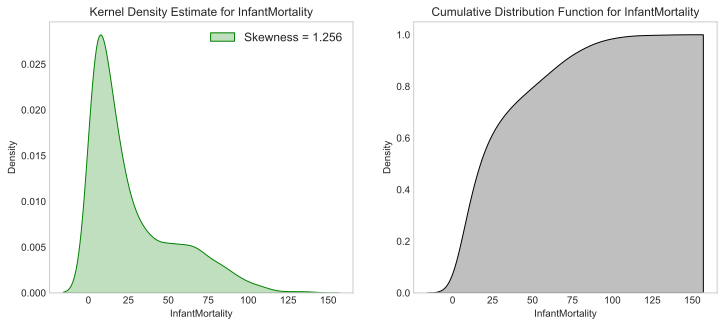

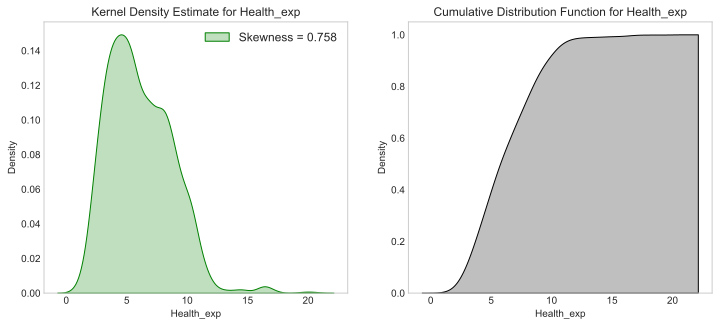

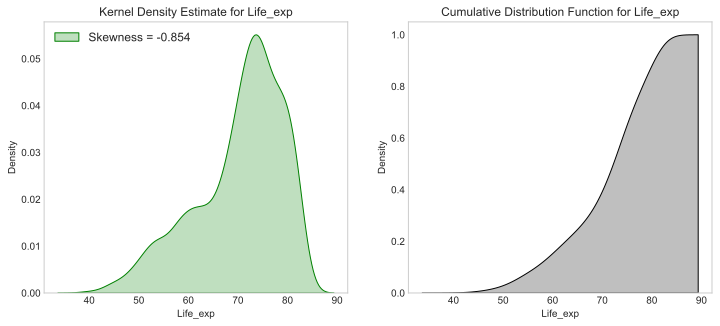

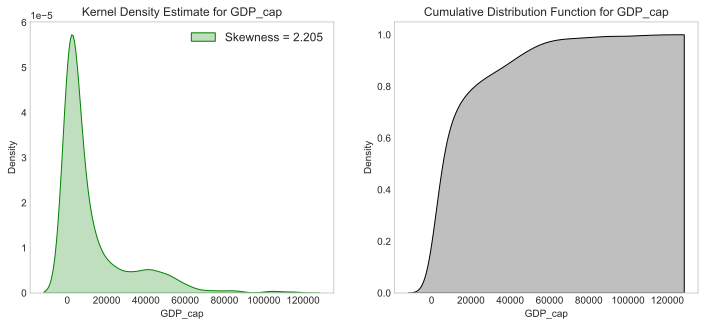

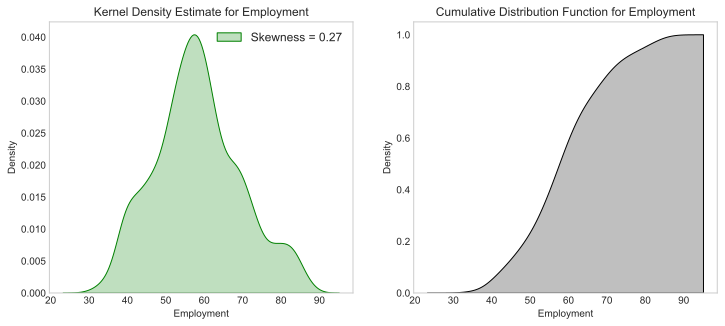

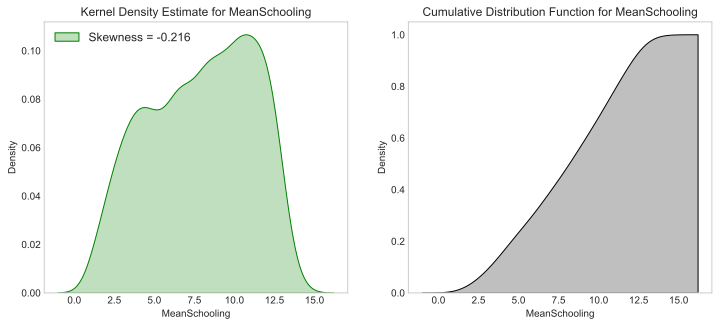

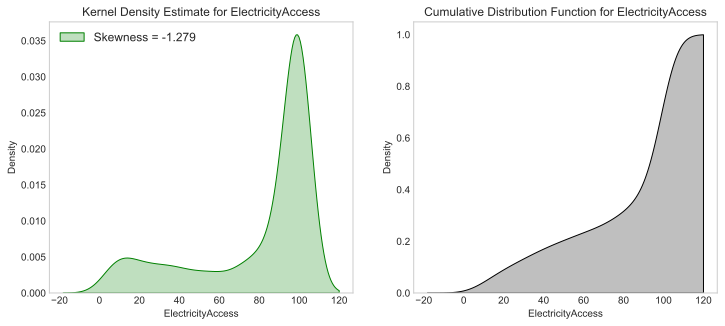

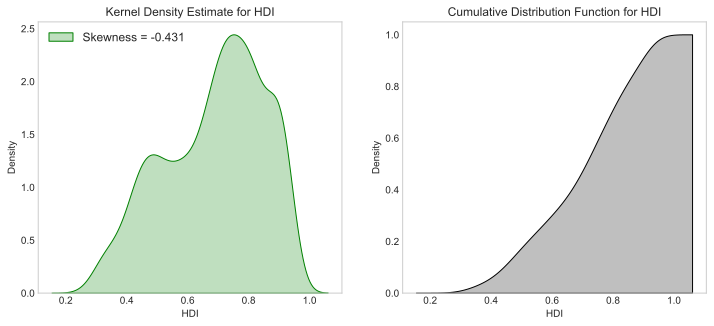

In [9]:
ea.show_skewness(data=train)

<u>Boxplots</u>

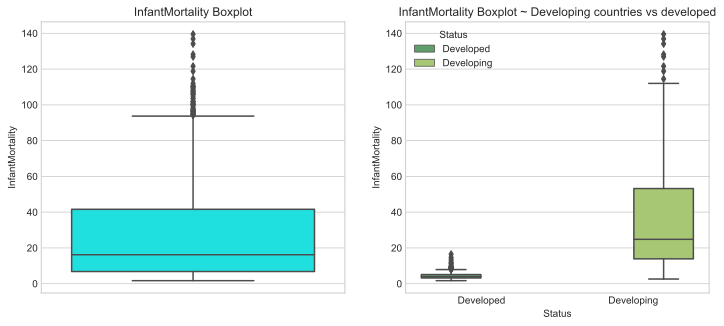

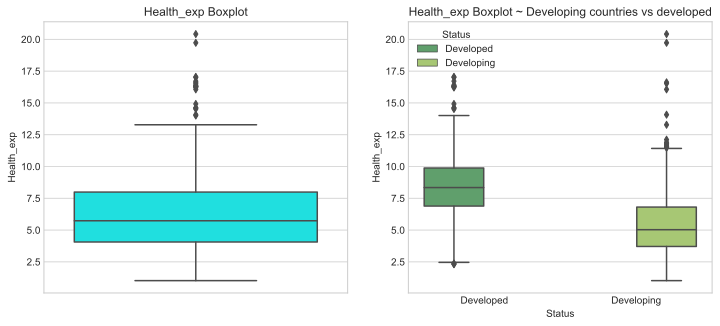

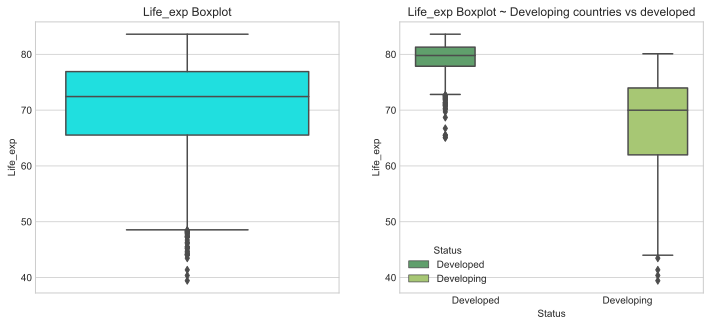

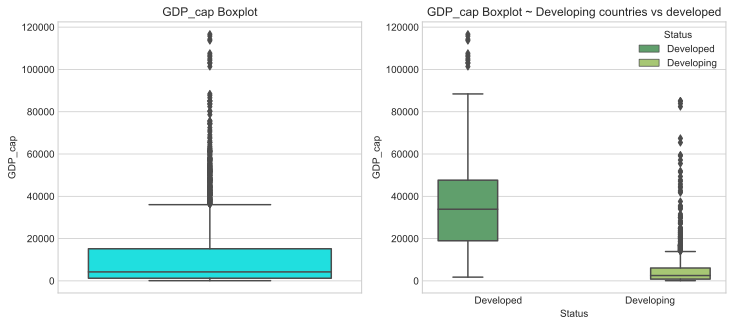

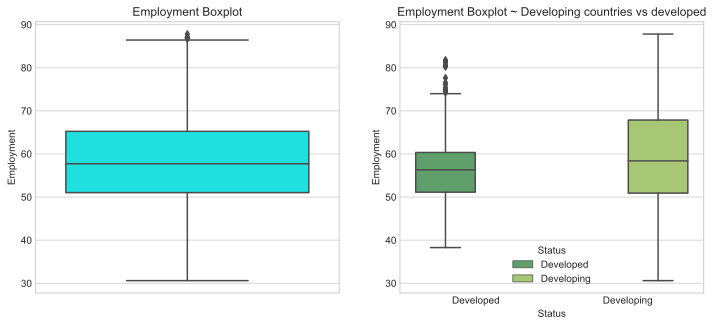

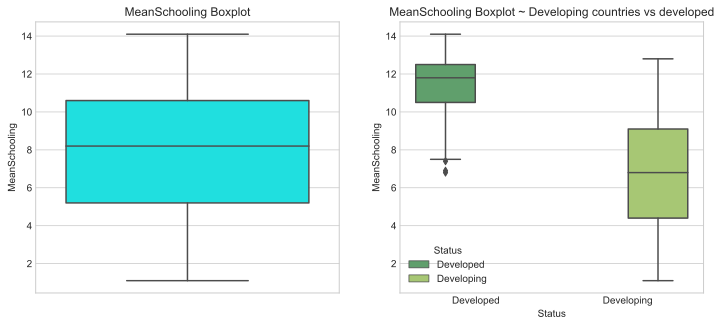

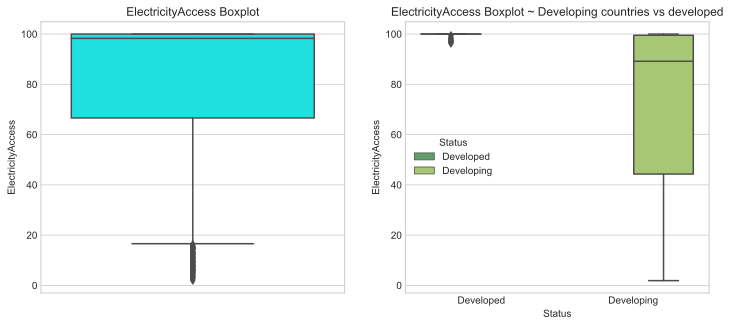

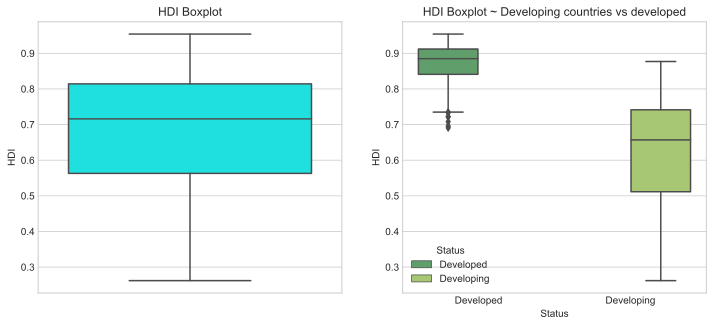

In [10]:
ea.display_boxplots(train)

#### <span style="color:black"><u>**Bivariate Analysis - Numeric vs Numeric**<a name="ba_n"></a><u></span>
    
- Correlation matrix
- Scatter plots with correlation calculations
    
<ins>Correlation</ins>

- [Correlation](https://towardsdatascience.com/what-is-correlation-975ea899aaed) is a statistical measure that expresses the extent to which two variables are linearly related. 
- For example as one variable increases the other might increase too (positive correlation), or on the other hand, as one variable increases, the other decreases (negative correlation). 
- It's a common tool for describing simple linear relationships that exist within the data, without making a statement about cause and effect. 
- Just because variables are correlated, an increase in one does not neccessarily cause the the movement of the other. Correlation does not imply causation.
- The method we will use to see if variables are correlated is Pearson's sample correlation coefficient, given by: 

    
<big><big>$$r = \frac{{}\sum_{i=1}^{n} (x_i - \overline{x})(y_i - \overline{y})}
{\sqrt{\sum_{i=1}^{n} (x_i - \overline{x})^2(y_i - \overline{y})^2}}.$$</big></big>

<ins>Some Properties of Correlation</ins> 
* $Corr(X, Y) = Corr(Y, X)$
* $P(Y = aX + b) = 1$ will imply either perfect positive or perfect negative correlation, depending on the slope. In this case, the two variables will move together in a perfectly straight line

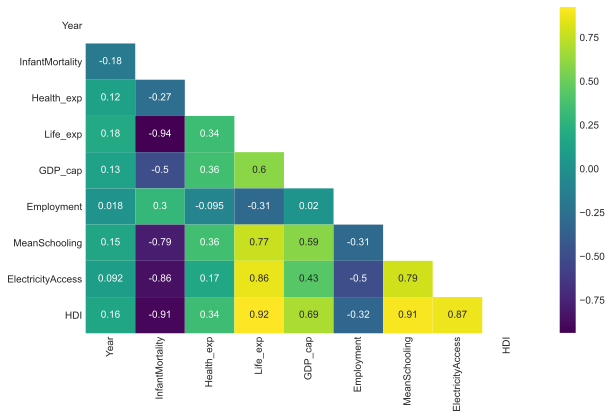

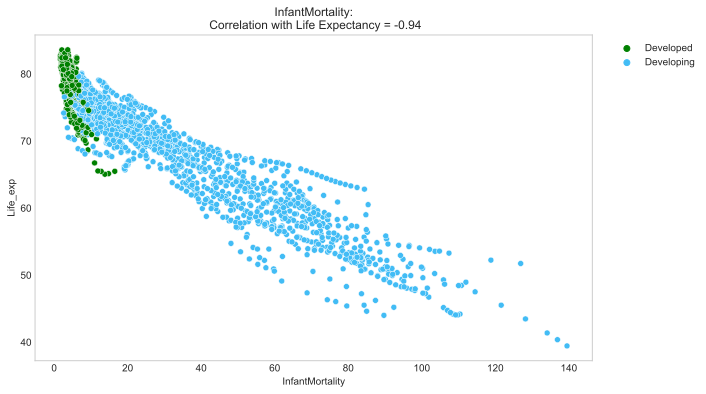

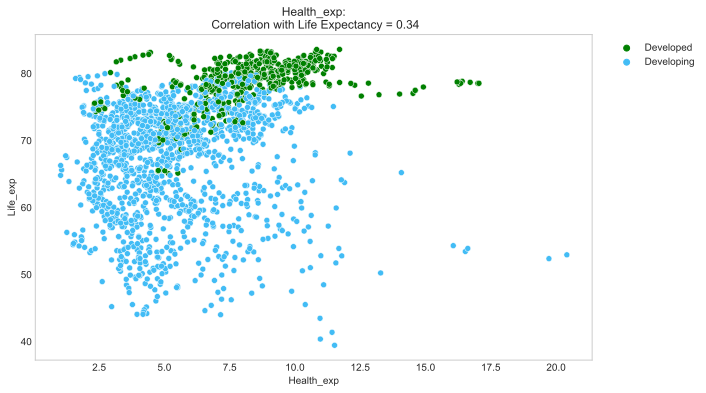

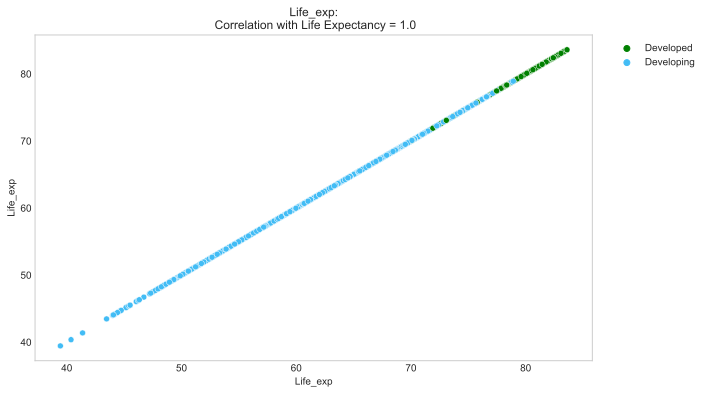

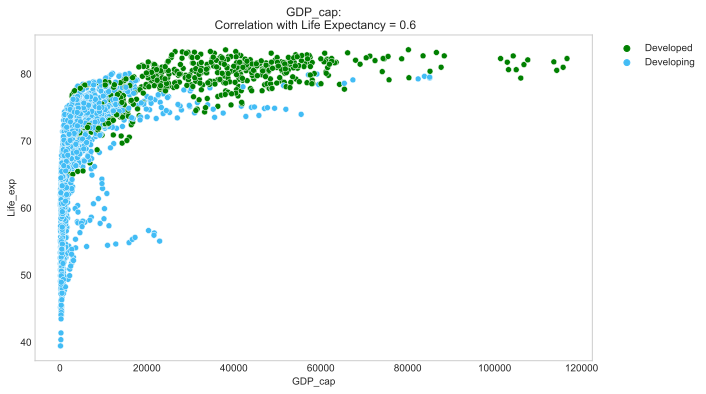

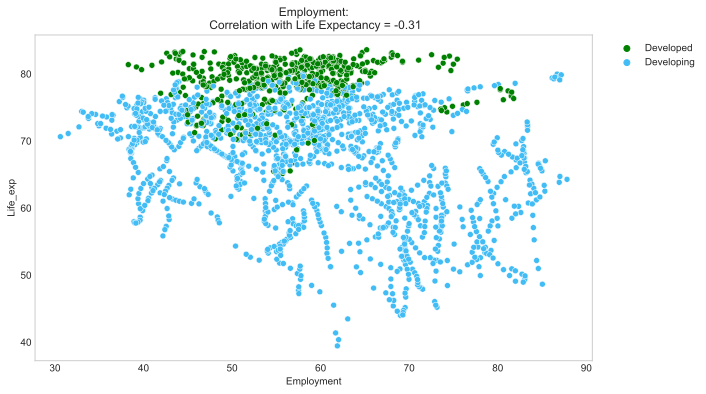

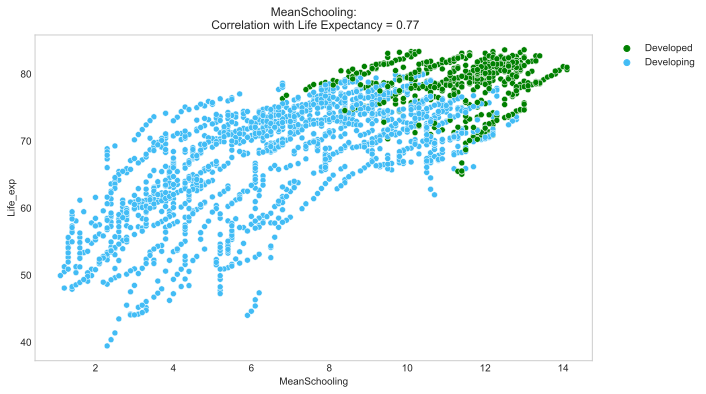

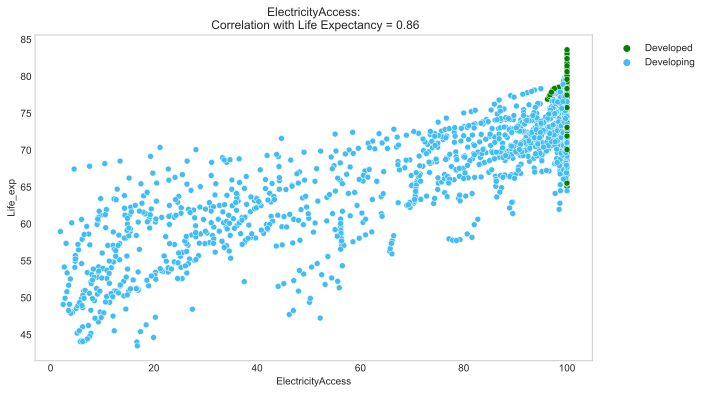

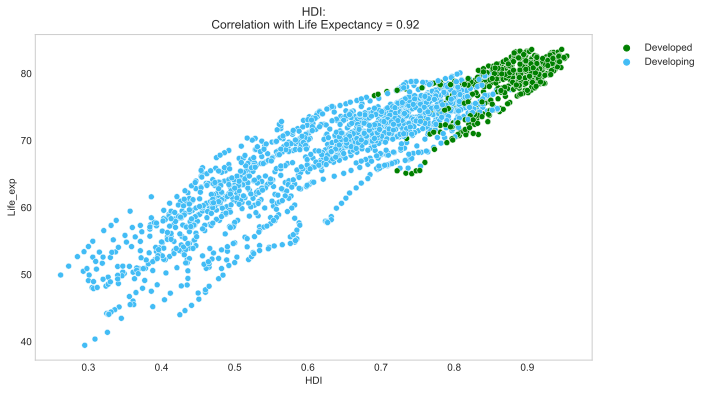

In [11]:
# Bi-variate analysis
ea.corr_heatmap(train)
for xvar in ea.numeric_variables(train):
    ea.plot_corr(data=train, xvar=xvar)

<u>Some thoughts</u>

* Surprisingly there is minimal correlation between health expenditure and life expectancy
* GDP per capita against life expectancy certainly doesn't follow a linear relationship. Might need to transform this feature. Perhaps a log transform might work
* Strong positive correlations included (HDI <-> Life Expectancy),  (Electricity Access <-> Life Expectancy), (Schooling <-> Life Expectancy)
* Strong negative correlation between Infant Mortality and Life Expectancy

<ins>Bivariate Outlier Detection - Mahalanobis Distance</ins>

* Observing bivariate scatterplots (above) is useful, though the [Mahalanobis Distance](https://www.statisticshowto.com/mahalanobis-distance/) (MD) is also a popular option. 
* The Mahalanobis Distance helps us find the distance between between a point and a multivariate distribution and is used for bivariate outlier detection as well as forming a big part of [Hotelling's T Squared Test](https://www.statistics.com/glossary/hotellings-t-square/). The general concepts of the Mahalanobis Distance can also be applied to [Principal Component Analysis](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) (PCA)
* The reason why MD is useful is because euclidean distance breaks down when the coviariance between two variables is non zero
* Observing the diagram below, the Euclidean distance from center of the cluster of points to the bottom red point is the same as the distance to the top right pink point, despite the bottom red point looking like a bivariate outlier. In situations like this the Mahalanobis Distance is useful

![md](MD.png)

To calculate the Mahalanobis Distance we first need the covariance matrix, which calculates the [covariance](https://www.investopedia.com/terms/c/covariance.asp) between each possible variable pairing. Covariance, like correlation can also be used to inform us as to whether two variables move in the same direction or in opposing directions. It does through telling us the joint variability of the two variables, and is given by the formula 

$$\text{Cov}({x,y})=\frac{\sum_{i=1}^{n}(x_{i}-\bar{x})(y_{i}-\bar{y})}{n-1}$$

Because Euclidean distance tends to fail in detecting bivariate outliers when two variables in question have reasonable positive/negative covariance, we would ideally like to rescale the coordinates to remove the covariance and thus, the correlation. 

To do this we calculate the [eigenvalues and eigenvectors](https://www.mathsisfun.com/algebra/eigenvalue.html) of the covariance matrix we are dealing with. An eigenvector tells us the vector that when multiplied by a particular matrix in question has the same impact as scaling the vector. The magnitude in which this vector is scaled is the eigenvalue, often represented as $\lambda$. If we are dealing with two variables $x$ and $y$, the span of the first eigenvector is the direction of greatest variability in the dataset and the second eigenvector is orthogonal to the first.

Now that the eigenvectors have been calculated, we take the each of our eigenvectors as new axes and shrink each axis by the square root of the corresponding eigenvalue. This in turn removes covariance between our data points, and now we are in a position to calculate Euclidean distance like usual. Essentially, all the data points in bivariate space are rescaled by compressing them in the direction of each eigenvector, but by different amounts which is ultimately dictated by the eigenvalue.

The formula for the Mahalanobis Distance is given by:

$$MD = \sqrt{(\vec{x} - \vec{m})^T \cdot C^{-1} \cdot (\vec{x} - \vec{m})}$$

Where $(\vec{x} - \vec{m})$ represents a matrix of distances of each datapoint from its mean and $C^{-1}$ is the inverse of the covariance matrix in question

---

The Mahalanobis distance does require multivariate normality, though the [Henze-Zirkler Test](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3927875/) can test for this

Null and alternate hypothesis:

$$H_0: \text{The variables follow a multivariate normal distribution}$$

$$H_1: \text{The variables are not multivariate normal}$$


In [12]:
ea.henze_zirkler(train, y='Life_exp', alpha=0.05)

Variables in Question  HZ Statistic  P-Value (alpha = 0.05)  \
0               Year and Life_exp         26.25                    0.00   
1    InfantMortality and Life_exp         65.38                    0.00   
2         Health_exp and Life_exp         40.79                    0.00   
3            GDP_cap and Life_exp        157.34                    0.00   
4         Employment and Life_exp         32.31                    0.00   
5      MeanSchooling and Life_exp         34.85                    0.00   
6  ElectricityAccess and Life_exp        119.31                    0.00   
7                HDI and Life_exp         34.30                    0.00   

   The Data is Bi-variate Normal?  
0                           False  
1                           False  
2                           False  
3                           False  
4                           False  
5                           False  
6                           False  
7                           False

None of the combos follow a multivariate normal distribution. So Mahalanobis Distances for the above scatterplots using the `sklearn.covariance.EllipticEnvelope()` class from sklearn might not be an option. Other techniques like [Density Based Spatial Clustering of Applications with Noise (DBSCAN)](https://en.wikipedia.org/wiki/DBSCAN) (non-parametric), [One-Class Support Vector Machines](https://www.datatechnotes.com/2020/04/anomaly-detection-with-one-class-svm.html) and [Isolation Forests](https://en.wikipedia.org/wiki/Isolation_forest) are useful. Basic One Class SVM below

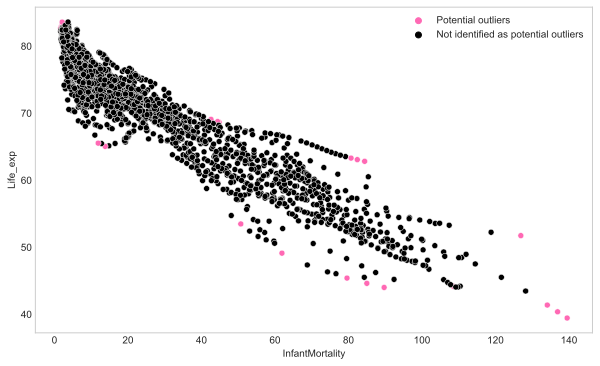

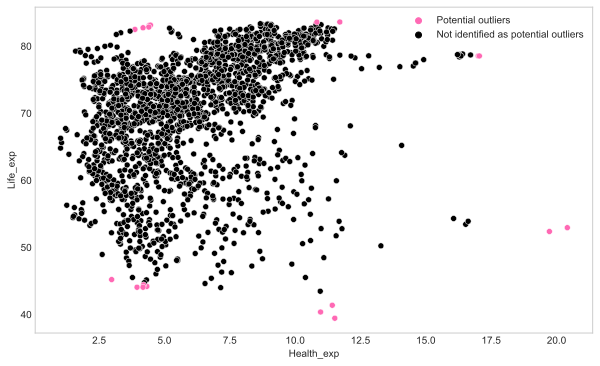

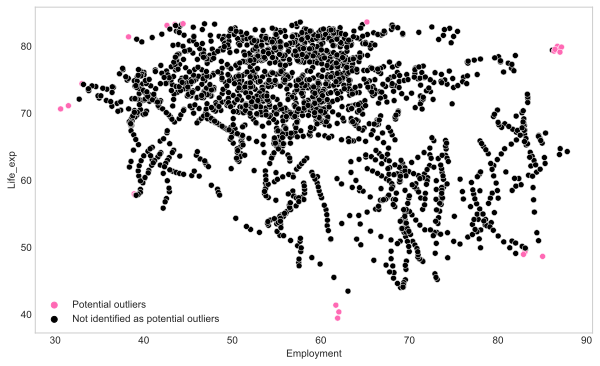

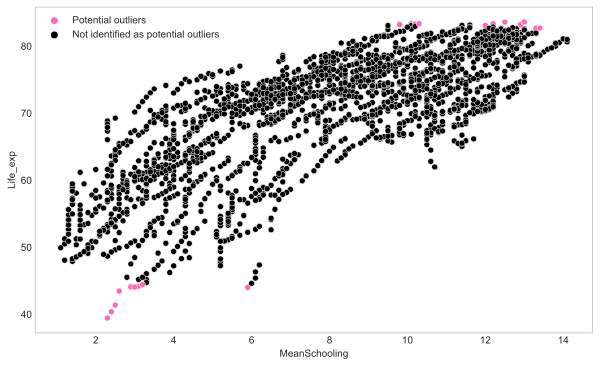

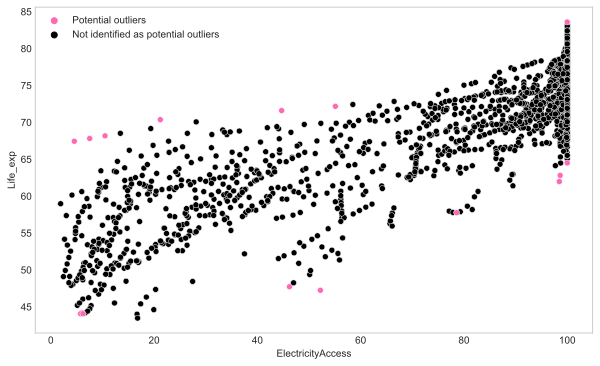

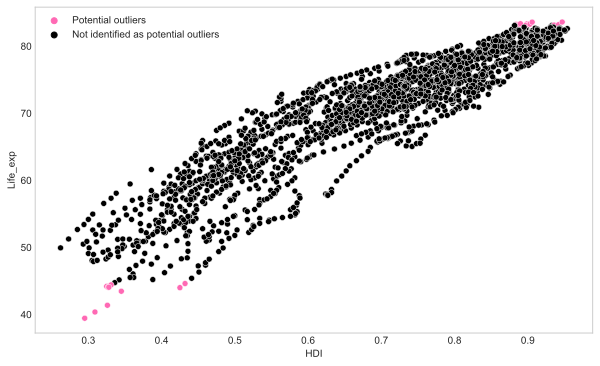

In [13]:
# One class SVM to algorithmically find potential bivariate outliers
for var in ['InfantMortality', 'Health_exp', 'Employment', 'MeanSchooling', 'ElectricityAccess', 'HDI']:
    ea.one_class_svm(train, var, y='Life_exp', kernel='rbf', gamma=0.001, nu=0.01)

For now I will trust that no substantial bivariate outliers exist in our data based on what I saw from the initial blue and green scatterplots and what One-Class-SVM predicted to be outliers (pink dots) for some of the variables I was interested in

#### <span style="color:black"><u>**Multivariate Analysis**<a name="ma"></a><u></span>

<u>Variance Inflation Factor</u>
* In the next notebook more in depth
* Here is a useful plot if you are familiar with the concept

/opt/anaconda3/envs/Models/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


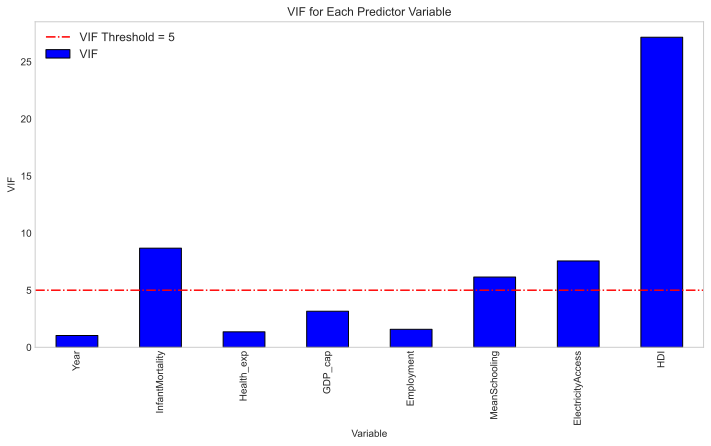

In [14]:
# Call the function
X = train.select_dtypes(include = 'number')
X = X.drop(['Life_exp'], axis = 1).dropna(axis = 0)

ea.display_vif(X, threshold=5);

As HDI has a very high VIF, if we were to build an Ordinary Least Squares model, multicollinearity would definitely be present. I won't drop the HDI variable right now, but the assumption that no multicollinearity exists in the model will be violated if we use OLS with these variables as our predictor variables. A high VIF for HDI is very unsurprising to me as the HDI in itself is an measure based off variables like income, mortality, employment and other factors (that are variables that already exist in our dataset)

#### <span style="color:black"><u>**Feature Transformations**<u></span>
    
Transforming features in a non linear way can:
- Help turn skewed data into more symetrically distributed data
- Make relationships more linear between a predictor and the response variable (helps linearise the data)
- Can help minimise heteroskedasticity in linear models
- Make data more evenly spread

    
Some transformations include:
    
* Log transformation: 
     * Reduces skew for right skewed data, though all values must be strictly positive
* Reciprocal transformation: 
     * Taking the reciprocal turns larger values into smaller values and vice versa. 
     * It is not defined when x is zero so we proceed with caution
* Square transformation: 
     * Mostly for left skewed data
     * http://seismo.berkeley.edu/~kirchner/eps_120/Toolkits/Toolkit_03.pdf (they made a nice point about moving up and down the ladder)
* Square root transformation: 
     * Reduces skewness of right skewed data, though all values must be strictly positive. 
     * Weaker than log transformation.
* Box Cox and Yeo Johnson
    * [Terrific resource](https://towardsdatascience.com/catalog-of-variable-transformations-to-make-your-model-works-better-7b506bf80b97)
    * Finds a lambda parameter that can help you get your data following a normal distribution
    * Check out the [PowerTransformer class from sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
    
    
A log transform for the GDP_cap variable might be nice as it was verey right skewed to begin with
    
    
Will be doing feature engineering using sklearn rather than pandas once I build models :)

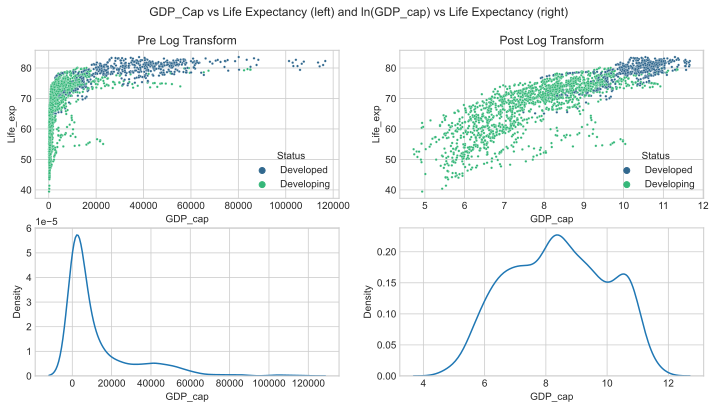

In [15]:
# Just wanted to preview and see what happened if we log transformed that GDP_Cap variable

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6))
fig.suptitle('GDP_Cap vs Life Expectancy (left) and ln(GDP_cap) vs Life Expectancy (right)')

sns.scatterplot(x = train.GDP_cap, y = train.Life_exp, s = 6, hue = train.Status, ax = ax1, palette = 'viridis')
sns.scatterplot(x = np.log(train.GDP_cap), y = train.Life_exp, s = 6, hue = train.Status, ax = ax2, palette = 'viridis')
sns.kdeplot(train.GDP_cap, ax=ax3)
sns.kdeplot(np.log(train.GDP_cap), ax=ax4)

ax1.set_title('Pre Log Transform')
ax2.set_title('Post Log Transform');

# Perthaps a log transform of the GDP feature could be useful 
# ...as it as reduced the skewness and has linearised the relationship with life excpectancy

In [16]:
# Save the updates to new csvs
train.to_csv('../data/Train_updated.csv', index=False)
test.to_csv('../data/Test_updated.csv', index=False)